In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import math
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import torchode
from constants import Dataset_Config, Model_Config
from util_functions import create_matrix_from_arange, create_sliding_window, median_smoothing_with_kernel

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df = pd.read_csv(Dataset_Config.DATASET_PATH.value)
df = df.drop('Unnamed: 0', axis=1)
df

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,14648.45,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,19124.28,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,19029.51,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,18923.65,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,104171.80,1107
...,...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,7464.13,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,7456.25,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,7421.00,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,51638.81,1


In [4]:
df.describe()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,14657.191773,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,34710.735892,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,31.690000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,9035.022500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,9946.195000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,10786.542500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,958471.430000,1133.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   Total time (s)             15064 non-null  float64
 9   RUL                        15064 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.1 MB


### No Null Values

The Dataset is made up of data from 14 different batteries.
We will split up this whole dataset into 14 dataframes, one for each battery.


In [6]:
# Since the cycle index of each battery starts at 1, we'll find rows where cycle index = 1
df[df["Cycle_Index"] == 1]

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL
0,1.0,2595.30,1151.4885,3.670,3.211,5460.001,6755.01,10777.82,14648.45,1112
1076,1.0,2604.00,1186.4955,3.666,3.213,5424.991,6706.02,10772.99,14663.71,1107
2155,1.0,2562.02,1140.9910,3.666,3.219,5452.993,6740.99,10836.00,14684.70,1107
3232,1.0,2566.08,1161.9830,3.667,3.214,5452.992,6740.99,10938.33,14782.11,1107
4313,1.0,2590.02,1239.0070,3.660,3.225,5376.000,6678.01,10821.98,14689.92,1133
5390,1.0,2609.47,1372.0000,3.650,3.228,5348.000,6678.02,11078.56,14963.45,1102
6468,1.0,2590.98,1154.9760,3.667,3.224,5452.992,6727.01,10819.42,14685.66,1107
7549,1.0,2590.50,1169.0240,3.667,3.206,5446.016,6734.02,10759.26,14627.49,1104
8629,1.0,2565.31,1186.4965,3.664,3.221,5439.007,6740.99,10999.07,14839.81,1107
9708,1.0,2587.94,1231.9990,3.661,3.223,5383.009,6678.02,10856.83,14720.42,1107


In [7]:
df['Total time (s)'] = df['Discharge Time (s)'] + df['Charging time (s)']
df['Charge:Discharge'] = df['Charging time (s)'] / df['Discharge Time (s)']
df['log Charge:Time constant current'] = np.log(df['Charging time (s)'] / df['Time constant current (s)'])
df.insert(len(df.columns.tolist())-1, 'RUL', df.pop('RUL'))

df

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),Charge:Discharge,log Charge:Time constant current,RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,13373.12,4.152822,0.467206,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,17908.99,1.417311,0.440087,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,17814.14,1.409348,0.432442,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,17708.31,1.397713,0.423034,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,121722.40,0.871997,0.063455,1107
...,...,...,...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,7449.32,8.668916,1.553674,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,7441.50,8.650249,1.552450,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,7406.24,8.629499,1.547451,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,8434.50,9.898977,1.898072,1


In [8]:
def split_dataset(df):
    indices = df[df["Cycle_Index"] == 1].index.to_list()
    split_dfs = []
    for i in range(len(indices)-1):
        df_sliced = df.iloc[indices[i]:indices[i+1], :].copy()
        split_dfs.append(df_sliced)
    final_sliced_df = df.iloc[indices[-1]:, :].copy()
    split_dfs.append(final_sliced_df)
    return split_dfs

In [9]:
split_dfs = split_dataset(df)
split_dfs[13]

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),Charge:Discharge,log Charge:Time constant current,RUL
14013,1.0,2590.02,1189.984000,3.664,3.226,5404.001,6706.02,10909.09,13499.11,4.211971,0.486591,1111
14014,2.0,7356.99,1232.000000,4.240,3.239,5446.016,6699.01,10598.02,17955.01,1.440538,0.458707,1110
14015,3.0,7329.02,1152.651333,4.243,3.243,5432.000,6684.99,10479.01,17808.03,1.429797,0.449509,1109
14016,4.0,7322.01,1127.007000,4.244,3.241,5439.004,6692.00,10395.00,17717.01,1.419692,0.440412,1108
14017,6.0,64837.43,1127.008000,4.288,3.246,5432.000,107572.09,107572.09,172409.52,1.659105,0.000000,1106
...,...,...,...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,7449.32,8.668916,1.553674,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,7441.50,8.650249,1.552450,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,7406.24,8.629499,1.547451,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,8434.50,9.898977,1.898072,1


In [10]:
split_dfs[13].index = range(len(split_dfs[13].iloc[:, -1]))
split_dfs[13]

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),Charge:Discharge,log Charge:Time constant current,RUL
0,1.0,2590.02,1189.984000,3.664,3.226,5404.001,6706.02,10909.09,13499.11,4.211971,0.486591,1111
1,2.0,7356.99,1232.000000,4.240,3.239,5446.016,6699.01,10598.02,17955.01,1.440538,0.458707,1110
2,3.0,7329.02,1152.651333,4.243,3.243,5432.000,6684.99,10479.01,17808.03,1.429797,0.449509,1109
3,4.0,7322.01,1127.007000,4.244,3.241,5439.004,6692.00,10395.00,17717.01,1.419692,0.440412,1108
4,6.0,64837.43,1127.008000,4.288,3.246,5432.000,107572.09,107572.09,172409.52,1.659105,0.000000,1106
...,...,...,...,...,...,...,...,...,...,...,...,...
1046,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,7449.32,8.668916,1.553674,4
1047,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,7441.50,8.650249,1.552450,3
1048,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,7406.24,8.629499,1.547451,2
1049,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,8434.50,9.898977,1.898072,1


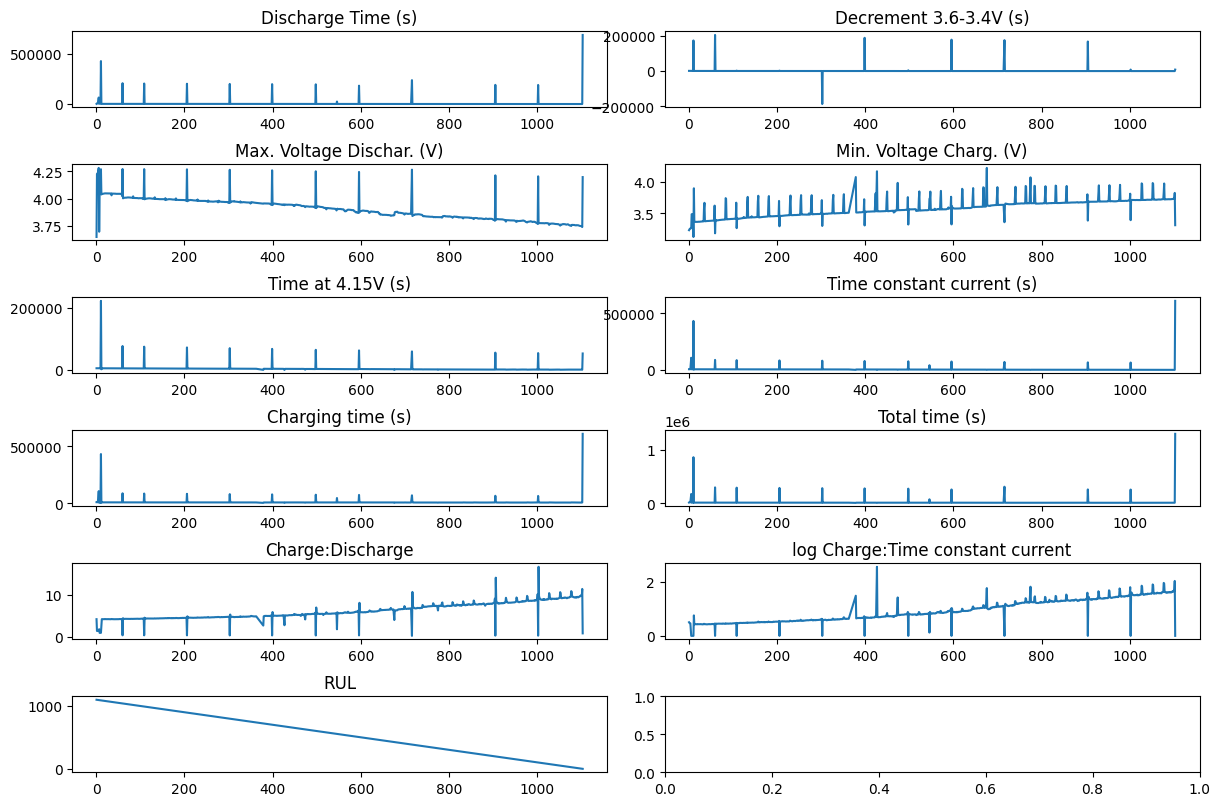

In [11]:
# Plot of all the features vs the cycle index (How the features change with time)
plot_nums = len(df.columns) - 1

fig, ax = plt.subplots(ncols=2, nrows=math.ceil(plot_nums/2), figsize=(12, 8))
fig.tight_layout()

for i in range(plot_nums):
    #print(int(plot_nums/2), int(i/2), i%2)
    ax[int(i/2), i%2].plot(split_dfs[5]["Cycle_Index"], split_dfs[5][df.columns[i+1]])
    ax[int(i/2), i%2].set_title(df.columns[i+1])

plt.subplots_adjust(hspace=0.75)
plt.show()

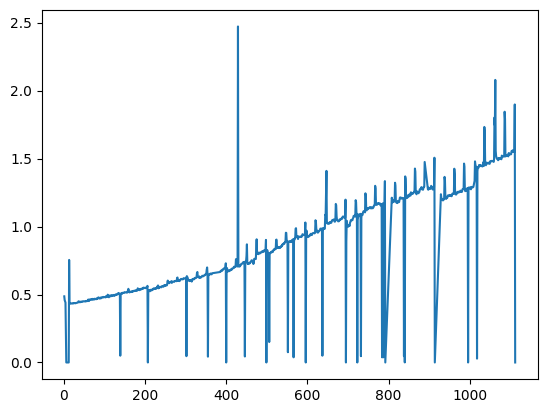

In [12]:
plt.plot(split_dfs[13]["Cycle_Index"], np.log(split_dfs[13]['Charging time (s)'] / split_dfs[13]['Time constant current (s)']))
plt.savefig('./report/imgs/LogChargeToTimeConstCurrentPlt.png')

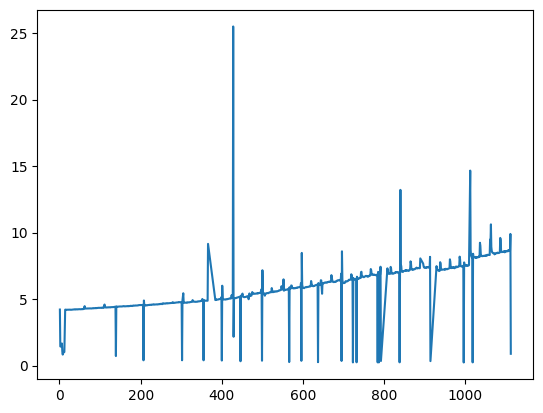

In [13]:
plt.plot(split_dfs[13]["Cycle_Index"], (split_dfs[13]['Charging time (s)'] / split_dfs[13]['Discharge Time (s)']))
plt.savefig('./report/imgs/ChargeToDischargePlt.png')

In [15]:
split_dfs[13].corr()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),Charge:Discharge,log Charge:Time constant current,RUL
Cycle_Index,1.000000,-0.032070,-0.017605,-0.624707,0.786138,-0.167403,-0.072038,-0.050477,-0.041190,0.748608,0.882889,-1.000000
Discharge Time (s),-0.032070,1.000000,0.515619,0.268673,-0.270109,0.869210,0.959701,0.957242,0.990451,-0.249288,-0.208511,0.032070
Decrement 3.6-3.4V (s),-0.017605,0.515619,1.000000,0.188947,-0.175418,0.512526,0.411409,0.406748,0.469318,-0.190929,-0.156247,0.017605
Max. Voltage Dischar. (V),-0.624707,0.268673,0.188947,1.000000,-0.553932,0.331420,0.247015,0.242164,0.258949,-0.314276,-0.433857,0.624707
Min. Voltage Charg. (V),0.786138,-0.270109,-0.175418,-0.553932,1.000000,-0.352113,-0.266441,-0.246321,-0.261697,0.679441,0.817230,-0.786138
Time at 4.15V (s),-0.167403,0.869210,0.512526,0.331420,-0.352113,1.000000,0.852928,0.848467,0.868737,-0.294528,-0.276987,0.167403
Time constant current (s),-0.072038,0.959701,0.411409,0.247015,-0.266441,0.852928,1.000000,0.999510,0.989064,-0.212065,-0.195034,0.072038
Charging time (s),-0.050477,0.957242,0.406748,0.242164,-0.246321,0.848467,0.999510,1.000000,0.987984,-0.186617,-0.167910,0.050477
Total time (s),-0.041190,0.990451,0.469318,0.258949,-0.261697,0.868737,0.989064,0.987984,1.000000,-0.222121,-0.191420,0.041190
Charge:Discharge,0.748608,-0.249288,-0.190929,-0.314276,0.679441,-0.294528,-0.212065,-0.186617,-0.222121,1.000000,0.853190,-0.748608


In [16]:
x_scaler = RobustScaler()
y_scaler = StandardScaler()
x_scaler.fit(pd.concat(split_dfs[:10], axis=0).iloc[:, 1:-1])
y_scaler.fit(pd.DataFrame(pd.concat(split_dfs[:10], axis=0).iloc[:, -1]))

scaled_split_dfs = []

for i in range(len(split_dfs)):
    scaled_split_dfs.append((np.concat((np.array(split_dfs[i].iloc[:, 0]).reshape(-1, 1), x_scaler.transform(split_dfs[i].iloc[:, 1:-1])), axis=1), y_scaler.transform(pd.DataFrame(split_dfs[i].iloc[:, -1]))))

scaled_split_dfs[2]

(array([[ 1.00000000e+00,  1.32222282e+00,  2.34057750e+00, ...,
          2.09115745e+00, -5.01053968e-01, -5.15418140e-01],
        [ 2.00000000e+00,  7.70085698e+00,  2.34852314e+00, ...,
          4.76817196e+00, -1.80716397e+00, -5.61147486e-01],
        [ 3.00000000e+00,  7.66681795e+00,  2.13827154e+00, ...,
          4.68570503e+00, -1.81198195e+00, -5.77888910e-01],
        ...,
        [ 1.10600000e+03, -8.48039085e-01, -7.18518279e-01, ...,
         -1.07187218e+00,  1.10972629e+00,  9.86082580e-01],
        [ 1.10700000e+03, -8.56969325e-01, -7.57066995e-01, ...,
         -5.72986233e-01,  1.55691088e+00,  1.41625208e+00],
        [ 1.10800000e+03,  8.72958339e+02,  2.56947732e+01, ...,
          7.36618124e+02, -2.06154952e+00, -1.33815403e+00]]),
 array([[ 1.71536841],
        [ 1.71226809],
        [ 1.70916776],
        ...,
        [-1.7104867 ],
        [-1.71358702],
        [-1.71668734]]))

In [17]:
window_size = Dataset_Config.SLIDING_WINDOW_SIZE.value
sliding_window_dfs = []
for i in range(len(scaled_split_dfs)):
    x_window, y_window = create_sliding_window(scaled_split_dfs[i][0], scaled_split_dfs[i][1], window_size)
    sliding_window_dfs.append((x_window, y_window))
sliding_window_dfs[5][0].shape, sliding_window_dfs[5][1].shape

((1059, 20, 11), (1059, 1))

In [18]:
TRAIN_BATTERIES_COUNT = Dataset_Config.TRAIN_BATTERIES_COUNT.value
TEST_BATTERIES_COUNT = Dataset_Config.TEST_BATTERIES_COUNT.value

train_dataset_x = torch.concat([torch.tensor(x) for x, y in sliding_window_dfs[TEST_BATTERIES_COUNT:TRAIN_BATTERIES_COUNT+TEST_BATTERIES_COUNT]])
train_dataset_y = torch.concat([torch.tensor(y) for x, y in sliding_window_dfs[TEST_BATTERIES_COUNT:TRAIN_BATTERIES_COUNT+TEST_BATTERIES_COUNT]])
test_dataset_x = torch.concat([torch.tensor(x) for x, y in sliding_window_dfs[:TEST_BATTERIES_COUNT]])
test_dataset_y = torch.concat([torch.tensor(y) for x, y in sliding_window_dfs[:TEST_BATTERIES_COUNT]])

test_dataset_x.shape

torch.Size([4237, 20, 11])

In [19]:
class SlidingWindowDataset(Dataset):
    def __init__(self, X_windows, y_windows):
        self.X_windows = torch.tensor(X_windows, dtype=torch.float32)
        self.y_windows = torch.tensor(y_windows, dtype=torch.float32)

    def __len__(self):
        return len(self.X_windows)

    def __getitem__(self, idx):
        return self.X_windows[idx], self.y_windows[idx]

# Create dataset and dataloader
train_dataset = SlidingWindowDataset(train_dataset_x, train_dataset_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

C:\Users\Shubham Mate\AppData\Local\Temp\ipykernel_7652\493168708.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_windows = torch.tensor(X_windows, dtype=torch.float32)
C:\Users\Shubham Mate\AppData\Local\Temp\ipykernel_7652\493168708.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_windows = torch.tensor(y_windows, dtype=torch.float32)


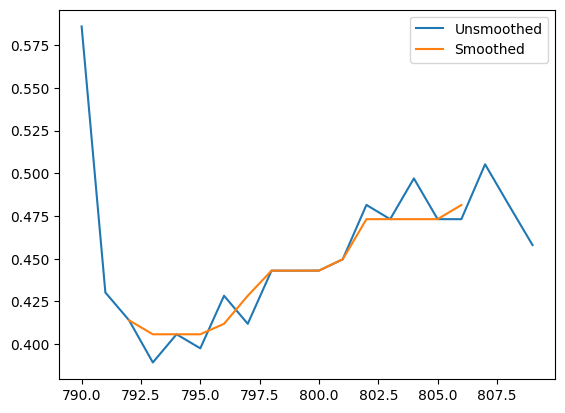

In [20]:
for x, y in train_dataloader:
    WINDOW_SIZE = Dataset_Config.SMOOTHING_WINDOW_SIZE.value
    smoothed_x0 = median_smoothing_with_kernel(x[0], window_size=WINDOW_SIZE)
    torch.set_printoptions(sci_mode=False)
    #print(smoothed_x0[WINDOW_SIZE // 2: -WINDOW_SIZE // 2])
    #print(x[0][:, 5], smoothed_x0[:, 5])
    plt.plot(x[0][:, 0], x[0][:, 10], label='Unsmoothed')
    plt.plot(x[0][WINDOW_SIZE // 2: -WINDOW_SIZE // 2, 0], smoothed_x0[WINDOW_SIZE // 2: -WINDOW_SIZE // 2, 10], label='Smoothed')
    plt.legend()
    plt.show()
    break

### We'll use first 10 batteries data as training set, and rest as test set

In [21]:
class ODEFunc(torch.nn.Module):
    def __init__(self, input_dim):
        super(ODEFunc, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, input_dim)
        )

    def forward(self, t, x):
        return self.net(x)


class ODERNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ODERNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn_cell = torch.nn.GRU(input_dim, hidden_dim, batch_first=True)  # RNN-like update
        
        self.ode_func = ODEFunc(hidden_dim)
        self.term = torchode.ODETerm(self.ode_func)
        self.step_method = torchode.Dopri5(term=self.term)
        self.step_size_controller = torchode.IntegralController(atol=1e-3, rtol=1e-3, term=self.term)
        self.adjoint = torchode.AutoDiffAdjoint(self.step_method, self.step_size_controller)
        
        self.fc =  torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, output_dim)
        ) 
    
    def forward(self, x, t):
        batch_size = x.size(0)
        h = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)  
        
        for i in range(t.size(1) - 1):

            out, h = self.rnn_cell(x[:, i, :].reshape(batch_size, 1, x.size(-1)), h)

            time_divs = create_matrix_from_arange(t[:, i], t[:, i+1], n = Model_Config.TIME_DIVS.value)

            problem = torchode.InitialValueProblem(y0=h.squeeze(0).to(device), t_eval=time_divs.to(device))
            sol = self.adjoint.solve(problem).ys.permute(1, 0, 2)[-1]
            h = sol.unsqueeze(0).contiguous()

        return self.fc(out)


In [22]:
model = ODERNN(10, Model_Config.HIDDEN_DIM.value, 1)
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Model_Config.LEARNING_RATE.value, weight_decay=Model_Config.REGULARIZATION_PARAMETER.value)
EPOCHS = Model_Config.EPOCHS.value
WINDOW_SIZE = Dataset_Config.SMOOTHING_WINDOW_SIZE.value

In [78]:
# Training Loop
model.train()
for epoch in range(EPOCHS):
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        for batch in x:
            batch[:, 1:] = torch.tensor(median_smoothing_with_kernel(batch[:, 1:], window_size=WINDOW_SIZE))

        pred = model(x[..., WINDOW_SIZE // 2: -WINDOW_SIZE // 2, 1:].to(device), x[..., WINDOW_SIZE // 2: -WINDOW_SIZE // 2, 0].to(device))

        loss = criterion(pred.view(-1), y.view(-1).to(device))
        loss.backward()
        optimizer.step()


        if i % 10 == 0:
            print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item()}, rmse: {root_mean_squared_error(y_scaler.inverse_transform(y.view(-1, 1).detach().numpy()), y_scaler.inverse_transform(pred.view(-1, 1).detach().cpu().numpy()))}')

Epoch 0, Batch 0, Loss: 1.0520634651184082, rmse: 330.8371276855469
Epoch 0, Batch 10, Loss: 0.4999960958957672, rmse: 228.07443237304688
Epoch 0, Batch 20, Loss: 0.12382424622774124, rmse: 113.50006103515625
Epoch 0, Batch 30, Loss: 0.09211698174476624, rmse: 97.89559173583984
Epoch 0, Batch 40, Loss: 0.05376605689525604, rmse: 74.79066467285156
Epoch 0, Batch 50, Loss: 0.06355525553226471, rmse: 81.31468200683594
Epoch 0, Batch 60, Loss: 0.049547575414180756, rmse: 71.79669952392578
Epoch 0, Batch 70, Loss: 0.03537067025899887, rmse: 60.661746978759766
Epoch 0, Batch 80, Loss: 0.028649214655160904, rmse: 54.594600677490234
Epoch 0, Batch 90, Loss: 0.032510608434677124, rmse: 58.15751266479492
Epoch 0, Batch 100, Loss: 0.02747764252126217, rmse: 53.466651916503906
Epoch 0, Batch 110, Loss: 0.029014315456151962, rmse: 54.94137191772461
Epoch 0, Batch 120, Loss: 0.03862433880567551, rmse: 63.390445709228516
Epoch 0, Batch 130, Loss: 0.0284966342151165, rmse: 54.44901657104492
Epoch 0, B

In [23]:
test_dataset = SlidingWindowDataset(test_dataset_x, test_dataset_y)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

C:\Users\Shubham Mate\AppData\Local\Temp\ipykernel_7652\493168708.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_windows = torch.tensor(X_windows, dtype=torch.float32)
C:\Users\Shubham Mate\AppData\Local\Temp\ipykernel_7652\493168708.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_windows = torch.tensor(y_windows, dtype=torch.float32)


In [26]:
actual = np.array([])
predicted = np.array([])
for x, y in test_dataloader:
    model.eval()
    for batch in x:
        batch[:, 1:] = torch.tensor(median_smoothing_with_kernel(batch[:, 1:], window_size=WINDOW_SIZE))
    pred = model(x[..., WINDOW_SIZE // 2: -WINDOW_SIZE // 2, 1:].to(device), x[..., WINDOW_SIZE // 2: -WINDOW_SIZE // 2, 0].to(device))
    loss = criterion(pred.view(-1), y.view(-1).to(device))
    actual = np.concatenate((actual, y_scaler.inverse_transform(y.view(-1, 1).detach().numpy()).flatten()))
    predicted = np.concatenate((predicted, y_scaler.inverse_transform(pred.view(-1, 1).detach().cpu().numpy()).flatten()))
    print(f'loss: {loss.item()}, Batch root mean square error: {root_mean_squared_error(y_scaler.inverse_transform(y.view(-1, 1).detach().numpy()), y_scaler.inverse_transform(pred.view(-1, 1).detach().cpu().numpy()))}')

loss: 0.022223161533474922, Batch root mean square error: 48.08351135253906
loss: 0.02914992719888687, Batch root mean square error: 55.06961441040039
loss: 0.030719459056854248, Batch root mean square error: 56.532745361328125
loss: 0.024850647896528244, Batch root mean square error: 50.846622467041016
loss: 0.02461394853889942, Batch root mean square error: 50.60388946533203
loss: 0.023508846759796143, Batch root mean square error: 49.454856872558594
loss: 0.026424672454595566, Batch root mean square error: 52.43220520019531
loss: 0.03461185842752457, Batch root mean square error: 60.007530212402344
loss: 0.029144801199436188, Batch root mean square error: 55.06476974487305
loss: 0.03536586835980415, Batch root mean square error: 60.65763473510742
loss: 0.028180018067359924, Batch root mean square error: 54.14569854736328
loss: 0.025950519368052483, Batch root mean square error: 51.959659576416016
loss: 0.02789131924510002, Batch root mean square error: 53.86762619018555
loss: 0.0340

In [32]:
root_mean_squared_error(actual, predicted), mean_squared_error(actual, predicted), mean_absolute_error(actual, predicted), r2_score(actual, predicted)

(np.float64(52.798106988443564),
 np.float64(2787.640101563133),
 np.float64(44.34963103003968),
 0.9722108244911756)

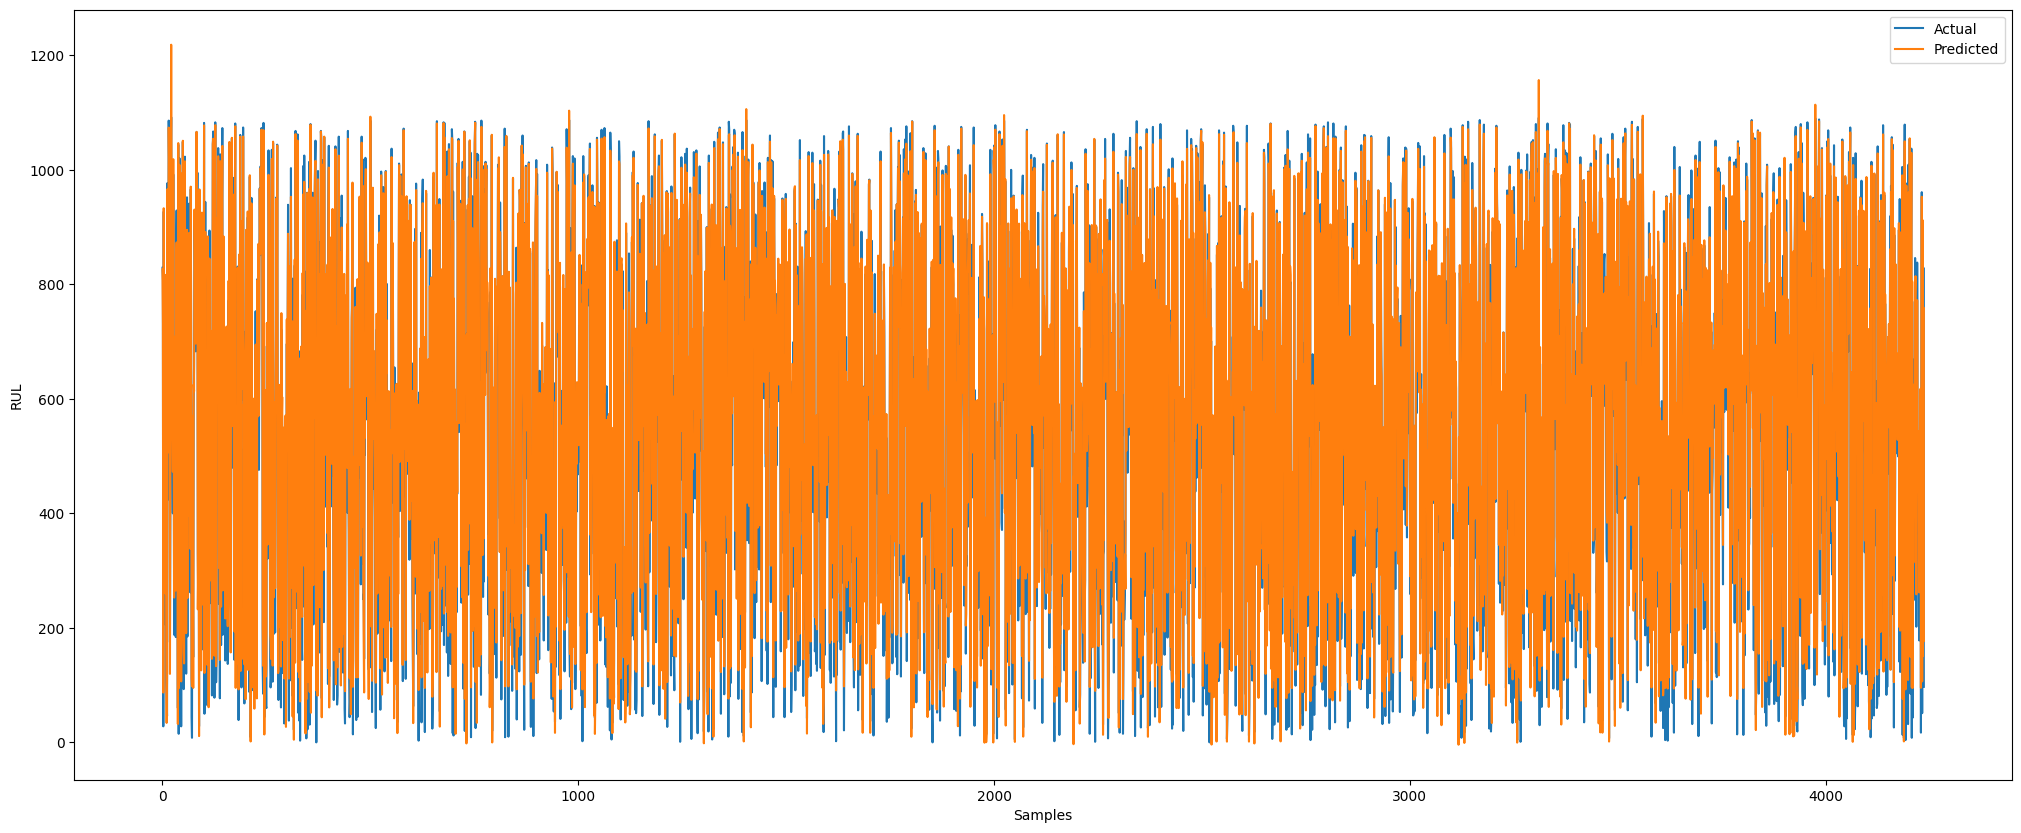

In [44]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(10)
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.savefig("./report/imgs/predicted.png")
plt.show()

In [82]:
torch.save(model.state_dict(), Model_Config.SAVED_MODELS_PATH.value / 'model_3.pth')

In [24]:
model.load_state_dict(torch.load(Model_Config.SAVED_MODELS_PATH.value / 'model_3.pth', weights_only=True))

<All keys matched successfully>